In [ ]:
#validation_data_dir = 'storage/test'
#test_data_dir = 'storage/train'

In [1]:
import pandas as pd
import numpy as np 
import itertools
import keras
from keras.applications.vgg16 import VGG16
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.models import Sequential 
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense, LeakyReLU 
from keras import applications  
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from keras import backend as K


from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline
import math  
import datetime
import time

Using TensorFlow backend.


In [2]:
#Default dimensions we found online
img_width, img_height = 224, 224  
   
#Create a bottleneck file
top_model_weights_path = 'bottleneck_fc_model.h5' 

# loading up our datasets
train_data_dir = 'storage/train'  
validation_data_dir = 'storage/test'
test_data_dir = 'storage/valid'
   
# number of epochs to train top model  
epochs = 7 #this has been changed after multiple model run  
# batch size used by flow_from_directory and predict_generator  
batch_size = 50

In [3]:
vgg16 = VGG16(include_top=False, weights='imagenet')

In [4]:
datagen = ImageDataGenerator(rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)  

In [5]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

start = datetime.datetime.now()

generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

nb_train_samples = len(generator.filenames)
num_classes = len(generator.class_indices)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))

bottleneck_features_train = vgg16.predict_generator(generator, predict_size_train)

np.save('bottleneck_features_train-vgg16.npy', bottleneck_features_train)

end= datetime.datetime.now() 
elapsed= end-start 
print ('Time: ', elapsed)

Found 3867 images belonging to 6 classes.


/home/evan13/miniconda3/envs/tensorflow/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:700: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/evan13/miniconda3/envs/tensorflow/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:708: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Time:  0:09:51.957371


In [6]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

start = datetime.datetime.now() 

datagen = ImageDataGenerator(rescale=1. / 255)

generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

nb_validation_samples = len(generator.filenames)

predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

bottleneck_features_validation = vgg16.predict_generator(
generator, predict_size_validation)

np.save('bottleneck_features_validation-vgg16.npy', bottleneck_features_validation)

end= datetime.datetime.now() 
elapsed= end-start 
print ('Time: ', elapsed)

Found 1018 images belonging to 6 classes.


/home/evan13/miniconda3/envs/tensorflow/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 33554432 bytes but only got 0. Skipping tag 516
  " Skipping tag %s" % (size, len(data), tag))
/home/evan13/miniconda3/envs/tensorflow/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 69337600 bytes but only got 0. Skipping tag 3072
  " Skipping tag %s" % (size, len(data), tag))
/home/evan13/miniconda3/envs/tensorflow/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 19988480 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/evan13/miniconda3/envs/tensorflow/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2046820352 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag

Time:  0:02:22.475254


In [7]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

start = datetime.datetime.now()

datagen = ImageDataGenerator(rescale=1. / 255)

generator = datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

nb_test_samples = len(generator.filenames)

predict_size_test = int(math.ceil(nb_test_samples / batch_size))

bottleneck_features_test = vgg16.predict_generator(
generator, predict_size_test)

np.save('bottleneck_features_test-vgg16.npy', bottleneck_features_test) 

end= datetime.datetime.now() 
elapsed= end-start 
print ('Time: ', elapsed)

Found 1030 images belonging to 6 classes.
Time:  0:02:23.510824


In [3]:
datagen_top = ImageDataGenerator(rescale=1./255)

In [4]:
#training data
generator_top = datagen_top.flow_from_directory(  
         train_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=False)  
   
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
# load the bottleneck features saved earlier  
train_data = np.load('bottleneck_features_train-vgg16.npy')  
   
# get the class lebels for the training data, in the original order  
train_labels = generator_top.classes  
   
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes)

Found 3867 images belonging to 6 classes.


In [5]:
#validation data
generator_top = datagen_top.flow_from_directory(  
         validation_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_validation_samples = len(generator_top.filenames)  
   
validation_data = np.load('bottleneck_features_validation-vgg16.npy')  
   

validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

Found 1018 images belonging to 6 classes.


In [6]:
#testing data
generator_top = datagen_top.flow_from_directory(  
         test_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_test_samples = len(generator_top.filenames)  
   
test_data = np.load('bottleneck_features_test-vgg16.npy')  
   

test_labels = generator_top.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 1030 images belonging to 6 classes.


In [7]:
NAME = 'VGG 16-{}'.format(int(time.time()))

#This is the best model we found. For additional models, check out I_notebook.ipynb
start = datetime.datetime.now()
model = Sequential()

model.add(Flatten(input_shape=train_data.shape[1:]))

model.add(Dense(256, activation='linear'))
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.5))
model.add(Dense(128, activation='linear'))
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.5))  
model.add(Dense(64, activation='linear'))
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=5)
checkpoint = ModelCheckpoint(filepath='xception.h5', monitor='val_acc', save_best_only=True)
early_stop = EarlyStopping(monitor='acc', patience=2)

history = model.fit(train_data, train_labels,
                    epochs=70,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    validation_split=0.2,
                    callbacks=[tensorboard, reduce_lr, checkpoint, early_stop])  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 test_data, test_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Train on 3867 samples, validate on 1018 samples
Epoch 1/70
3867/3867 [==============================] - 3s 866us/step - loss: 1.8004 - acc: 0.2783 - val_loss: 1.2652 - val_acc: 0.6277
Epoch 2/70
3867/3867 [==============================] - 2s 623us/step - loss: 1.4077 - acc: 0.4533 - val_loss: 0.9766 - val_acc: 0.6542
Epoch 3/70
3867/3867 [==============================] - 3s 803us/step - loss: 1.2062 - acc: 0.5400 - val_loss: 0.7831 - val_acc: 0.7436
Epoch 4/70
3867/3867 [==============================] - 3s 778us/step - loss: 1.0604 - acc: 0.6067 - val_loss: 0.7826 - val_acc: 0.7161
Epoch 5/70
3867/3867 [==============================] - 3s 797us/step - loss: 0.9459 - acc: 0.6442 - val_loss: 0.6886 - val_acc: 0.7583
Epoch 6/70
3867/3867 [==============================] - 3s 810us/step - loss: 0.8430 - acc: 0.6868 - val_loss: 0.5712 - val_acc: 0.8075
Epoch 7/70
3867/3867 [==============================] - 3s 793us/step - loss: 0.7501 - acc: 0.7298 - val_loss: 0.5107 - val_acc: 0.8251


In [13]:
import cv2

In [14]:
img = cv2.imread('image-1.jpg')
img.shape

(195, 146, 3)

In [15]:
img = np.expand_dims(img, axis=0)

In [16]:
img.shape

(1, 195, 146, 3)

In [17]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np

# dimensions of our images    -----   are these then grayscale (black and white)?
img_width, img_height = 224, 224

# load the model we saved
#model = load_model('bottleneck_fc_model.h5')

# Get test image ready
test_image = image.load_img('image-1.jpg', target_size=(img_width, img_height))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)

test_image = test_image.reshape(img_width, img_height*3)    # Ambiguity!
# Should this instead be: test_image.reshape(img_width, img_height, 3) ??

result = model.predict(test_image, batch_size=1)
print(result)

ValueError: Error when checking input: expected flatten_1_input to have 4 dimensions, but got array with shape (224, 672)

In [20]:
model.predict(, test_labels)

SyntaxError: invalid syntax (<ipython-input-20-7ad50ff753b4>, line 1)

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 500)               12544500  
_________________________________________________________________
dropout_7 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               50100     
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_9 (Dropout)          (None, 50)                0         
__________

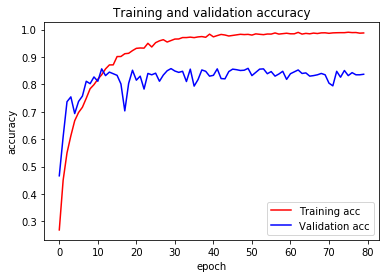

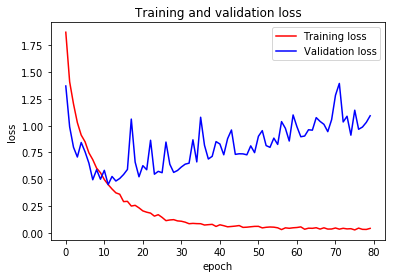

In [22]:

#Graphing our training and validation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

In [25]:
results_train_vgg16 = model.evaluate(test_data, test_labels)
results_train_vgg16

1030/1030 [==============================] - 0s 462us/step


[1.3023903864101298, 0.8233009707580492]

In [26]:
y_hat = model.predict(test_data)
y_test = test_labels

In [27]:
def get_metrics():
  # Converted continuous probabilities to binary to get F1 score
    y_hate = []
    for i in range(0,y_hat.shape[0]):
        a = [1 if metric == y_hat[i].max() else 0 for metric in y_hat[i]]
        y_hate.append(a)
        y_pred = np.array(y_hate)
  
    return 'F1: {}'.format(f1_score(y_true=y_test, y_pred= y_pred, average = 'weighted')), \
    'precision: {}'.format(precision_score(y_true=y_test, y_pred= y_pred, average = 'weighted')), \
    'recall: {}'.format(recall_score(y_true=y_test, y_pred= y_pred, average = 'weighted')) 

get_metrics()

('F1: 0.8195660322909909',
 'precision: 0.8302958608110669',
 'recall: 0.8233009708737864')

In [28]:
y_hate = []
for i in range(0,y_hat.shape[0]):
    a = [1 if metric == y_hat[i].max() else 0 for metric in y_hat[i]]
    y_hate.append(a)
    y_pred = np.array(y_hate)

In [29]:
classes = ['Dutch Colonial', 'Greek Revival', 'Spanish Revival', 'Tudor', 'Victorian - Queen Anne', 'Victorian - Second Empire']

classification_metrics = classification_report(y_test, y_pred)
print(classification_metrics)

              precision    recall  f1-score   support

           0       0.90      0.62      0.74       175
           1       0.77      0.93      0.84       170
           2       0.82      0.94      0.88       179
           3       0.85      0.73      0.79       175
           4       0.84      0.87      0.86       182
           5       0.78      0.85      0.81       149

   micro avg       0.82      0.82      0.82      1030
   macro avg       0.83      0.82      0.82      1030
weighted avg       0.83      0.82      0.82      1030
 samples avg       0.82      0.82      0.82      1030



In [30]:

#To get better visual of the confusion matrix:
def plot_confusion_matrix(cm, classes,
             normalize=False,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
    #Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
#     print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

Confusion matrix, without normalization


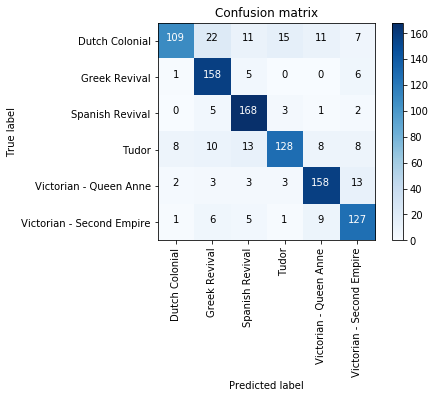

In [31]:

# Get Confusion matrix
cm_ = confusion_matrix(y_test.argmax(axis = 1), y_pred.argmax(axis = 1))
classes_ = ['Dutch Colonial', 'Greek Revival', 'Spanish Revival', 'Tudor', 'Victorian - Queen Anne', 'Victorian - Second Empire']
plot_confusion_matrix(cm_, classes = classes_, normalize=False, \
                      title='Confusion matrix')

Confusion matrix, without normalization


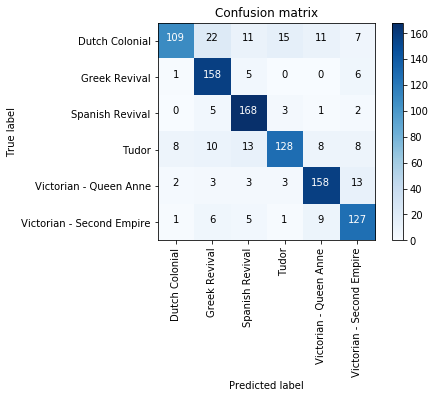

In [33]:
cm_ = confusion_matrix(y_test.argmax(axis = 1), y_pred.argmax(axis = 1))
classes_ = ['Dutch Colonial', 'Greek Revival', 'Spanish Revival', 'Tudor', 'Victorian - Queen Anne', 'Victorian - Second Empire']
plot_confusion_matrix(cm_, classes = classes_, normalize=False, \
                      title='Confusion matrix')